# Malaria: Evaluate

In [1]:
# load model and history
import numpy as np
np.random.seed(1)

from keras.models import load_model
model = load_model('malaria_model.h5')

import pickle
with open('malaria_history.pickle', 'rb') as f:
    [h] = pickle.load(f)   

Using TensorFlow backend.


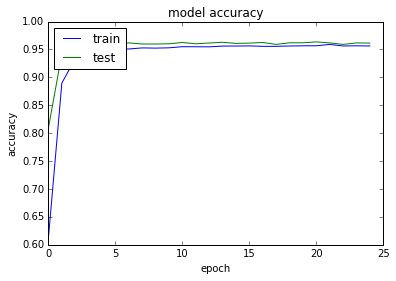

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(h['acc'])
plt.plot(h['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

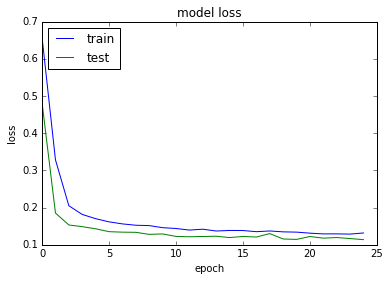

In [3]:
# summarize history for loss
plt.plot(h['loss'])
plt.plot(h['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [4]:
# evaluate model using images that have not been seen to the classifier
# load and scale images using keras
# scale pixel values to a range of 0 - 1
# get image processors for prediction
# classes will be extracted automatically from subdirectories

import keras
from keras.preprocessing.image import ImageDataGenerator, load_img 

predDir  = './predData'

pred_datagen = ImageDataGenerator(rescale=1./255)

prediction_generator = pred_datagen.flow_from_directory(
        predDir,
        target_size=(64, 64),
        batch_size=1,
        shuffle=False,
        class_mode='binary'
)


Found 2756 images belonging to 2 classes.


In [5]:
# use keras' in-built pipeline to get evaluation accuracy
prediction_generator.reset()
loss, acc = model.evaluate_generator(prediction_generator, steps=prediction_generator.samples)
print('Loss {}'.format(loss))
print('Accuracy {}'.format(acc))

Loss 0.122898277619
Accuracy 0.958272859216


In [6]:
# sanity check: manually predict labels for new blood samples
# and calculate accuracy
# both accuracies should be identical!
prediction_generator.reset()
y_pred = model.predict_generator(prediction_generator, steps=prediction_generator.samples, verbose=1)
print('Manually calculated accuracy {}'.format( np.mean( prediction_generator.classes == np.transpose(np.round(y_pred)))))

2746/2756 [============================>.] - ETA: 0sManually calculated accuracy 0.958272859216


In [7]:
# plot confusion matrix and classification report

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

print('Confusion Matrix')
y_predR = np.round(y_pred)
confMat = confusion_matrix(prediction_generator.classes, y_predR)
print(confMat)

print('Classification Report')
target_names = ['Parasitized', 'Uninfected']

print(classification_report(prediction_generator.classes, y_predR, target_names=target_names))

Confusion Matrix
[[1317   61]
 [  54 1324]]
Classification Report
             precision    recall  f1-score   support

Parasitized       0.96      0.96      0.96      1378
 Uninfected       0.96      0.96      0.96      1378

avg / total       0.96      0.96      0.96      2756



In [8]:
# get ROC false positive, true psoitive rates and thresholds
# to plot ROC curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import auc

fpr_keras, tpr_keras, thresholds_keras = roc_curve(prediction_generator.classes, y_pred)

# get area under the curve
auc_keras = auc(fpr_keras, tpr_keras)

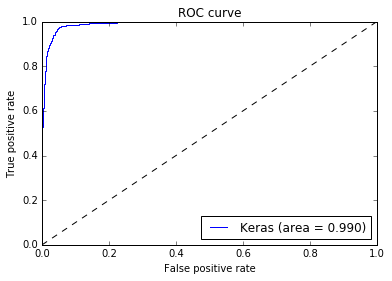

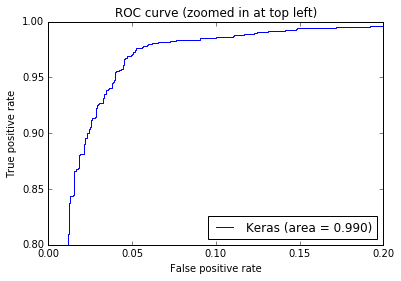

In [9]:
# plot ROC curve

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

1/1 [==============================] - 0s


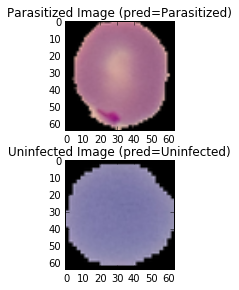

In [11]:
# optional: get a random image of each class from the prediction
# set and manually classify its label

import os
from random import randint

def listDirFP(d):
    return [os.path.join(d, f) for f in os.listdir(d)]

def preProcessImg(fImg):
    img = load_img(fImg)
    img = np.reshape(img,[1,64,64,3])
    img = img/255.0
    return img

# get a random parasitized and uninfected file
pFiles = listDirFP( os.path.join(predDir, 'Parasitized'))
uFiles = listDirFP( os.path.join(predDir, 'Uninfected'))

pImg = preProcessImg( pFiles[randint(0, pFiles.__len__())] )
uImg = preProcessImg( uFiles[randint(0, pFiles.__len__())] )

pSc = model.predict_classes(pImg)
uSc = model.predict_classes(uImg)

labDict = {0:'Parasitized', 1:'Uninfected'}

fig, axs = plt.subplots(2,1)
fig.tight_layout()
axs[0].imshow(pImg[0,:,:,:])
axs[0].set_title('Parasitized Image (pred={})'.format(labDict[np.asscalar(pSc)]))

axs[1].imshow(uImg[0,:,:,:])
axs[1].set_title('Uninfected Image (pred={})'.format(labDict[np.asscalar(uSc)]))